In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as cat
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap
import re

base_dir = 'data/'

import os

for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.linear_model import LinearRegression
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from datetime import datetime
import gc
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 1000)

data/sample_submission.csv
data/reduce_test.csv
data/train_labels.csv
data/test.csv
data/data-science-bowl-2019.zip
data/reduce_train.csv
data/train.csv
data/specs.csv


In [2]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv(base_dir + 'train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(base_dir + 'test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(base_dir + 'train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(base_dir + 'specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(base_dir + 'sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

train, test, train_labels, specs, sample_submission = read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [3]:
train.installation_id.unique().shape

(17000,)

In [4]:
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 11)

In [5]:
train.installation_id.unique().shape

(3614,)

In [6]:
#Credits go to Andrew Lukyanenko

def encode_title(train, test, train_labels):
    # encode title
    # 将title和event_code拼接起来
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    
    # 找到train和test都有的title_event_code，一共有398个，test只有384个，少了14个
    # {'Air Show_4080',
    #  'Bubble Bath_4080',
    #  'Bug Measurer (Activity)_4080',
    #  'Cart Balancer (Assessment)_4080',
    #  'Chest Sorter (Assessment)_4080',
    #  'Dino Dive_4080',
    #  'Dino Drink_4080',
    #  'Egg Dropper (Activity)_4080',
    #  'Fireworks (Activity)_4080',
    #  'Happy Camel_4080',
    #  'Leaf Leader_4080',
    #  'Mushroom Sorter (Assessment)_4080',
    #  'Pan Balance_4080',
    #  'Watering Hole (Activity)_2010'}
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    
    # make a list with all the unique 'titles' from the train and test set
    # 找到train和test都有的title，一共有44个
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    
    # make a list with all the unique 'event_code' from the train and test set
    # 找到train和test都有的event_code，一共有42个
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    
    # 找到train和test都有的event_id, 一共有379个，test只有365个，少了14个
    # {'01ca3a3c',
    #  '0ce40006',
    #  '119b5b02',
    #  '13f56524',
    #  '1b54d27f',
    #  '29a42aea',
    #  '2ec694de',
    #  '611485c5',
    #  '7fd1ac25',
    #  'ab4ec3a4',
    #  'bfc77bd6',
    #  'dcb1663e',
    #  'e4d32835',
    #  'ecc6157f'}
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    
    # make a list with all the unique worlds from the train and test set
    # 找到train和test共有的world，一共有4个
    # ['MAGMAPEAK', 'CRYSTALCAVES', 'TREETOPCITY', 'NONE']
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    
    # create a dictionary numerating the titles
    # 建立title(activity)和索引的键值对
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    
    # 建立索引和title(activate)的键值对
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    
    # 建立world和索引的键值对
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    
    # 找到train和test含accessment的type的title
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    
    # replace the text titles with the number titles from the dict
    # 将train、test和train_labels的title原值用键值对的索引来表示
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train_labels['title'] = train_labels['title'].map(activities_map)
    
    # 将train和test的world的原值用键值对的索引来表示
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    
    # 建立了一个{0:4100, 1:4100, ... 43:4100}的键值对
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    # 要把'Bird Measurer (Assessment)'的键值对值改成4110
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    # convert text into datetime
    # 用pandas的datatime的方式返回了原来的时间戳
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    # 返回了修改后的train、test、train_labels、title和event_code的键值对、共有的event_code，索引和title(activate)的键值对，含accessment的title，共有的event_code，title和event_code的拼接
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

# get usefull dict with maping encode
train, test, train_labels, win_code, \
list_of_user_activities, list_of_event_code, \
activities_labels, assess_titles, list_of_event_id,\
all_title_event_code = encode_title(train, test, train_labels)

In [7]:
activity_game_titles = ['All Star Sorting', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Air Show', 'Crystals Rule', 'Bug Measurer (Activity)', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Watering Hole (Activity)', 'Dino Drink', 'Bubble Bath', 'Bottle Filler (Activity)', 'Dino Dive', 'Chow Time', 'Chicken Balancer (Activity)', 'Happy Camel', 'Leaf Leader', 'Pan Balance', 'Egg Dropper (Activity)']
game_titles = ['All Star Sorting', 'Air Show', 'Crystals Rule', 'Scrub-A-Dub', 'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time', 'Happy Camel', 'Leaf Leader', 'Pan Balance']
media_sequence = {'Welcome to Lost Lagoon!': 19, 'Tree Top City - Level 1':17, 'Ordering Spheres':61, 'Costume Box':61,'12 Monkeys':109, 'Tree Top City - Level 2':25, "Pirate's Tale":80, 
                  'Treasure Map':156, 'Tree Top City - Level 3':26, 'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18, 
                  'Balancing Act':72,'Lifting Heavy Things':118, 'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19, 'Heavy, Heavier, Heaviest':61}

In [8]:
len(list_of_user_activities), len(activity_game_titles), len(game_titles)

(44, 19, 11)

In [9]:
def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

def get_4020_acc(df,counter_dict):
    
    for e in ['Cauldron Filler (Assessment)','Bird Measurer (Assessment)','Mushroom Sorter (Assessment)','Chest Sorter (Assessment)']:
        
        Assess_4020 = df[(df.event_code == 4020) & (df.title==activities_map[e])]   
        true_attempts_ = Assess_4020['event_data'].str.contains('true').sum()
        false_attempts_ = Assess_4020['event_data'].str.contains('false').sum()

        measure_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
        counter_dict[e+"_4020_accuracy"] += (counter_dict[e+"_4020_accuracy"] + measure_assess_accuracy_) / 2.0
    
    return counter_dict

In [10]:
# this is the function that convert the raw data into processed features
# 用来提取一个installation_id的特征
def get_data(user_sample, test_set=False):
    all_assessments = []
    last_activity = 0
    
    user_type_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0} # 单设备type统计，不区分title，递增性
    
    # event_count
    Assessment_mean_event_count = 0  # 单设备评估的平均事件数
    Game_mean_event_count = 0   # 单设备游戏的平均事件数
    Activity_mean_event_count = 0 # 单设备活动的平均事件数
    # game
    accumulated_game_miss = 0     
    mean_game_round = 0         # 单设备平均游戏回合  
    mean_game_duration = 0      # 单设备平均游戏持续事件 
    mean_game_level = 0         # 单设备平均游戏等级
    # 用于统计准确率的频次
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}  # 单设备准确率统计，不区分title，递增性
    accumulated_accuracy_group = 0  # 单设备准确率平均得分，不区分title，递增性
    accumulated_accuracy = 0        # 单设备准确率平均值，不区分title
    accumulated_correct_attempts = 0  # 单设备累计正确尝试
    accumulated_uncorrect_attempts = 0  # 单设备累计错误尝试
    accumulated_actions = 0   # 单设备累计动作
    
    counter = 0    # 评估的次数
    sessions_count = 0    # session的次数
    
    # 
    positive_words = "play again|did it|job|wow|cool|nice|amazing|exactly|Great|awe|That's it|just right|good|Alright|gold|That's right|All right|right amount|Well done|you're right|happy|won|Whoa"
    negative_words = "try again|too|Almost|n't|but|Whoops|Oops|not right|Uh oh"
    accumulated_positive_events = 0
    accumulated_negative_events = 0
    accumulated_positive_title = {'accumulated_positive_'+t: 0 for t in activity_game_titles}
    accumulated_negative_title = {'accumulated_negative_'+t: 0 for t in activity_game_titles}
    accumulated_positive_title_ratio = {'accumulated_positive_ratio_'+t: 0 for t in activity_game_titles}
    accumulated_negative_title_ratio = {'accumulated_negative_ratio_'+t: 0 for t in activity_game_titles}
    accumulated_won_game = {'accumulated_won_game_count_'+g: 0 for g in game_titles}
    
#     time_spent_each_act = {t+"_time": 0 for t in list_of_user_activities}
#     time_spent_each_acts = {t+"_time": [] for t in list_of_user_activities}
#     time_spent_each_act_mean = {t+"_time_mean": 0 for t in list_of_user_activities}
    
    # 时间
    durations = []
    clip_durations = []       # 单设备视频时长
    Activity_durations = []   # 单设备活动时长
    Game_durations = []      # 单设备游戏时长
    
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}   # 上一次title_accessment的准确率
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code} # 单设备event_code的统计
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}   # 单设备event_id的统计
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()}    # 单设备title统计
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code} # 单设备title_event_code统计
    
    # 根据Assessment
    type_count_clip = {'clip_' + title: 0 for title in assess_titles}
    type_count_activity = {'activity' + title: 0 for title in assess_titles}
    type_count_assessment = {'assessment' + title: 0 for title in assess_titles}
    type_count_game = {'game' + title: 0 for title in assess_titles}
    
    
    # i 是game_session, session 是 game_session中的一行，并且按照时间顺序
    for i, session in user_sample.groupby('game_session', sort=False): 
        # 取了type、title的键值对和文字
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        
        if(session_type=='Game' or session_type=='Activity'):
#             time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
#             time_spent_each_act[session_title_text + "_time"] += time_spent
#             time_spent_each_acts[session_title_text + "_time"].append(time_spent)
#             time_spent_each_acts[session_title_text + "_time"].append(time_spent)

            sum_positive_events = session['event_data'].str.contains(positive_words, flags=re.IGNORECASE).sum()
            sum_negative_events = session['event_data'].str.contains(negative_words, flags=re.IGNORECASE).sum()
            accumulated_positive_events += sum_positive_events
            accumulated_negative_events += sum_negative_events
            accumulated_positive_title['accumulated_positive_'+session_title_text] += sum_positive_events
            accumulated_negative_title['accumulated_negative_'+session_title_text] += sum_negative_events
            p = accumulated_positive_title['accumulated_positive_'+session_title_text]
            n = accumulated_negative_title['accumulated_negative_'+session_title_text]
            accumulated_positive_title_ratio['accumulated_positive__ratio_'+session_title_text] = p/(p+n) if (p+n)>0 else 0
            accumulated_negative_title_ratio['accumulated_negative__ratio_'+session_title_text] = n/(p+n) if (p+n)>0 else 0
        
        if(session_type=='Clip'):
            clip_durations.append((media_sequence[activities_labels[session_title]]))
#             time_spent = media_sequence[session_title_text]
#             time_spent_each_act[session_title_text + "_time"] += time_spent
#             time_spent_each_acts[session_title_text + "_time"].append(time_spent)
        elif(session_type=='Activity'):
            Activity_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
        elif (session_type == 'Game'):
            game_s = session[session.event_code == 2030]   
            misses_cnt = cnt_miss(game_s)        
            accumulated_game_miss += misses_cnt 
            
            accumulated_won_game['accumulated_won_game_count_'+session_title_text]+=session['event_data'].str.contains('play again', flags=re.IGNORECASE).sum()
            
            Game_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/2.0  # ？？？ 啥计算
            except:
                pass
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/2.0
            except:
                pass
            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) /2.0
            except:
                pass
            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) /2.0
            except:
                pass
        
        # 如果是评估类而且有多条记录，并且是，测试集或者是有多条记录的game_session，否则只有一条的评估不能产生价值？
        # Assessment 改进猜想：根据Assessment title来评估
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            
            # 找 4100 或者 (bird是4110)的记录，这是一条尝试评估, game_session对应唯一的title、type、world
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            
            # 累加尝试评估后正确或者错误的次数
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            # 单设备评估
            features = user_type_count.copy()
            features.update(last_accuracy_title.copy()) # （if delete:这是先验了上一次没有先验上几次评估，并且没有评估title）
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            
            # 积极和消极词汇
            features.update(accumulated_positive_title)
            features.update(accumulated_negative_title)
            features.update(accumulated_positive_title_ratio)
            features.update(accumulated_negative_title_ratio)
            
            features.update(accumulated_won_game.copy())
            
             # 唯一标识
            features['installation_id'] = session['installation_id'].iloc[-1]
            features['session_title'] = session['title'].iloc[0]
            
            # session
            features['installation_session_count'] = sessions_count
            
            # 事件数
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            
            # 游戏
            features['accumulated_game_miss'] = accumulated_game_miss
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)

            # positive & negative events
            features['accumulated_positive_events'] = accumulated_positive_events
            features['accumulated_negative_events'] = accumulated_negative_events
            positive_negative_events = accumulated_positive_events + accumulated_negative_events
            features['positive_events_ratio'] = accumulated_positive_events/positive_negative_events if positive_negative_events > 0 else 0
            features['negative_events_ratio'] = accumulated_negative_events/positive_negative_events if positive_negative_events > 0 else 0
            accumulated_positive_events = 0
            accumulated_negative_events = 0    
                
            # the accurace is the all time wins divided by the all time attempts
            # 计算本次评估的准确率
            accuracy = true_attempts/(true_attempts + false_attempts) if (true_attempts + false_attempts) != 0 else 0
            last_accuracy_title['acc_' + session_title_text] = accuracy
            
            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            # 导出accuracy_group(labels)的方法
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else: # accuracy == 1 / 3
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            
            #持续时间
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
            if Activity_durations == []:
                features['Activity_duration_mean'] = 0
                features['Activity_duration_std'] = 0
            else:
                features['Activity_duration_mean'] = np.mean(Activity_durations)
                features['Activity_duration_std'] = np.std(Activity_durations)
            if Game_durations == []:
                features['Game_duration_mean'] = 0
                features['Game_duration_std'] = 0
            else:
                features['Game_duration_mean'] = np.mean(Game_durations)  # 游戏平均时间
                features['Game_duration_std'] = np.std(Game_durations)    # 游戏时间方差
                
#             time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
#             time_spent_each_act[session_title_text + "_time"] += time_spent
#             time_spent_each_acts[session_title_text + "_time"].append(time_spent)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)
            
            # 累计正确和错误的尝试
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts
            accumulated_uncorrect_attempts += false_attempts
            # 准确率平均值 = (准确率 + 准确率 ...) / n
            # features['accumulated_accuracy'] = accumulated_accuracy / counter if counter > 0 else 0
            # accumulated_accuracy += accuracy
            # 准确率的平均得分  (得分 + 得分 ...) / n
            features['accumulated_accuracy_group'] = accumulated_accuracy_group / counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            
            counter += 1   # 评估次数
        
            features['accumulated_actions'] = accumulated_actions # 累计动作
            
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter     
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        sessions_count += 1
        
        accumulated_actions += len(session)
        if last_activity != session_type: # 感觉这个判断可以删除
            user_type_count[session_type] += 1
            last_activitiy = session_type         
                
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [11]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (installation_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
#         break; # debug
    for installation_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
#         break; # debug
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [12]:
reduce_train.shape

(17690, 1032)

In [13]:
reduce_train.head()

,Clip,Activity,Assessment,Game,acc_Mushroom Sorter (Assessment),acc_Cauldron Filler (Assessment),acc_Cart Balancer (Assessment),acc_Chest Sorter (Assessment),acc_Bird Measurer (Assessment),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,acf5c23f,c0415e5c,363c86c9,bb3e370b,b5053438,923afab1,1beb320a,3ccd3f02,0ce40006,15a43e5b,1340b8d7,dcb55a27,37937459,119b5b02,6f4bd64e,6c930e6e,d51b1749,7da34a02,5b49460a,d06f75b5,28f975ea,c58186bf,77261ab5,f50fc6c1,7f0836bf,e5734469,9d29771f,bfc77bd6,b012cd7f,3323d7e9,1b54d27f,7ab78247,0db6d71d,b120f2ac,7ad3efc6,86ba578b,93edfe2e,85de926c,b80e5e84,30df3273,56817e2b,28a4eb9a,9ed8f6da,a1192f43,d88e8f25,2b9272f4,6bf9e3e1,28ed704e,13f56524,1c178d24,ecc36b7f,47f43a44,155f62a4,c7128948,4bb2f698,a29c5338,b88f38da,26fd2d99,6088b756,c7fe2a55,9b01374f,29bdd9ba,15f99afc,eb2c19cd,90d848e0,a1bbe385,250513af,5859dfb6,28520915,08ff79ad,56cd3b43,ad2fc29c,bd612267,99abe2bb,87d743c1,e37a2b78,cdd22e43,16667cc5,1375ccb7,3d63345e,3bb91ced,c6971acf,f6947f54,bd701df8,a16a373e,5f0eb72c,587b5989,d3f1e122,5c3d2b2f,ec138c1c,9e4c8c7b,00c73085,3babcb9b,9e6b7fb5,795e4a37,47026d5f,84b0e0c8,461eace6,e694a35b,ac92046e,a6d66e51,a76029ee,e3ff61fb,88d4a5be,c51d8688,cf7638f3,3afb49e6,53c6e11a,abc5811c,cf82af56,6aeafed4,5e812b27,6d90d394,a0faea5d,a8876db3,a44b10dc,ecaab346,3bf1cf26,9de5e594,5be391b5,022b4259,d2278a3b,6077cc36,beb0a7b9,86c924c4,51102b85,3d8c61b0,58a0de5c,3a4be871,bcceccc6,ea296733,ab3136ba,de26c3a6,d88ca108,363d3849,c1cac9a2,90efca10,2dcad279,7ec0c298,f54238ee,3d0b9317,db02c830,7525289a,7040c096,0413e89d,67aa2ada,65a38bf7,2b058fe3,cc5087a3,6043a2b4,a7640a16,06372577,29f54413,8af75982,37ee8496,15ba1109,46cd75b4,4d6737eb,d3640339,3bb91dda,69fdac0a,4c2ec19f,b2e5b0f1,907a054b,2ec694de,5f5b2617,1996c610,4901243f,dcaede90,74e5f8a7,1bb5fbdb,8d7e386c,7d093bf9,6c517a88,30614231,f71c4741,27253bdc,6f445b57,a8efe47b,828e68f9,4a09ace1,3b2048ee,731c0cbe,c54cf6c5,44cb4907,598f4598,2230fab4,5de79a6a,e7e44842,92687c59,55115cbd,2a512369,4a4c3d21,9c5ef70c,b74258a0,df4940d3,8d748b58,562cec5f,bdf49a58,29a42aea,71fe8f75,0330ab6a,e9c52111,2a444e03,1af8be29,499edb7c,4e5fc6f5,05ad839b,67439901,0a08139c,e7561dd2,bbfe0445,5d042115,1575e76c,89aace00,0d18d96c,4b5efe37,85d1b0de,84538528,1325467d,8b757ab8,e5c9df6f,6f8106d9,dcb1663e,6cf7d25c,7d5c30a2,d185d3ea,3edf6747,e57dd7af,2c4e6db0,4d911100,14de4c5d,e79f3763,f56e0afc,b2dba42b,3afde5dd,7cf1bc53,d9c005dd,0086365d,bc8f2793,99ea62f3,6f4adc4b,25fa8af4,daac11b0,070a5291,63f13dd7,3ee399c3,3dcdda7f,532a2afb,31973d56,26a5a3dd,d122731b,76babcde,ab4ec3a4,5a848010,15eb4a7d,93b353f2,857f21c0,90ea0bac,37db1c2f,e64e2cfd,19967db1,48349b14,1cc7cfca,83c6c409,d2659ab4,8ac7cce4,709b1251,9554a50b,ca11f653,51311d7a,fcfdffb6,08fd73f3,884228c8,b7dc8128,77c76bc5,df4fe8b6,cb1178ad,cb6010f8,160654fd,565a3990,d02b7a8e,d3268efa,9d4e7b25,9b4001e4,f5b8c21a,e4f1efe6,f3cd5473,611485c5,01ca3a3c,2dc29e21,c74f40cd,832735e1,1f19558b,a5e9da97,792530f8,a5be6304,71e712d8,3ddc79c3,392e14df,d45ed6a1,37c53127,65abac75,9ee1c98c,73757a5e,3dfd4aa4,8fee50e2,47efca07,b7530680,45d01abe,7372e1a5,46b50ba8,5154fc30,f806dc10,9e34ea74,7dfe6d8a,f32856e4,e080a381,a1e4395d,d2e9262e,c7f7f0e1,f7e47413,e720d930,9b23e8ee,e04fb33d,c189aaf2,5e109ec3,04df9b66,77ead60d,fd20ea40,b1d5101d,ea321fb1,9ce586dd,33505eae,7423acbc,17113b36,ad148f58,c952eb01,763fc34e,38074c54,262136f4,7961e599,222660ff,3bfd1a65,1cf54632,02a42007,3393b68b,16dffff1,56bcd38d,a52b92d5,49ed92e9,804ee27f,0d1da71f,5290eab1,36fa3ebe,ecc6157f,736f9581,c2baf0bd,4ef8cdd3,7fd1ac25,5348fd84,c277e121,5c2f29ca,a2df0760,f28c589a,5e3ea25a,a592d54e,a8a78786,8f094001,91561152,fbaf3456,e4d32835,cfbd47c8,f93fc684,d38c2fd7,895865f3,2fb91ec1,756e5507,8d84fa81,Tree Top City - Level 3,Slop Problem,Balancing Act,Happy Camel,Egg Dropper (Activity),Crystals Rule,Sandcastle Builder (Activity),Lifting Heavy Things,Chow Time,Chest Sorter (Assessment),Mag

In [14]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [15]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
#             c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]   
            c = np.abs(np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1])  
            if c > 0.995:  # 相关性
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 0.9999999999999999
2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434878118
3: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.9999839030068793
4: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.9965084543995759
5: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965259434878118
6: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966123918733654
7: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
8: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998050146713992
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068793
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733654
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434878118
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.9965084543995759
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146713992
15: FEAT_A: 2050 FEAT_B: accumulated_positi

114: FEAT_A: 1b54d27f FEAT_B: Watering Hole (Activity)_2010 - Correlation: 1.0
115: FEAT_A: 7ab78247 FEAT_B: b80e5e84 - Correlation: 0.9998336590281087
116: FEAT_A: 7ab78247 FEAT_B: Egg Dropper (Activity)_3110 - Correlation: 0.9998336590281087
117: FEAT_A: 7ab78247 FEAT_B: Egg Dropper (Activity)_3010 - Correlation: 1.0
118: FEAT_A: 0db6d71d FEAT_B: Chest Sorter (Assessment)_4020 - Correlation: 1.0
119: FEAT_A: b120f2ac FEAT_B: d45ed6a1 - Correlation: 0.9979707847816691
120: FEAT_A: b120f2ac FEAT_B: c277e121 - Correlation: 0.9999983835744553
121: FEAT_A: b120f2ac FEAT_B: All Star Sorting_3020 - Correlation: 0.9999983835744553
122: FEAT_A: b120f2ac FEAT_B: All Star Sorting_3120 - Correlation: 0.9979707847816691
123: FEAT_A: b120f2ac FEAT_B: All Star Sorting_2025 - Correlation: 1.0
124: FEAT_A: b120f2ac FEAT_B: accumulated_negative_All Star Sorting - Correlation: 0.9995085114845523
125: FEAT_A: 7ad3efc6 FEAT_B: 65a38bf7 - Correlation: 0.999978626569043
126: FEAT_A: 7ad3efc6 FEAT_B: Cart B

218: FEAT_A: 795e4a37 FEAT_B: Cart Balancer (Assessment)_3010 - Correlation: 1.0
219: FEAT_A: 84b0e0c8 FEAT_B: ea321fb1 - Correlation: 0.9993007600205109
220: FEAT_A: 84b0e0c8 FEAT_B: Chicken Balancer (Activity)_3110 - Correlation: 1.0
221: FEAT_A: 84b0e0c8 FEAT_B: Chicken Balancer (Activity)_3010 - Correlation: 0.9993007600205109
222: FEAT_A: 461eace6 FEAT_B: Egg Dropper (Activity)_4020 - Correlation: 1.0
223: FEAT_A: e694a35b FEAT_B: Fireworks (Activity)_4020 - Correlation: 1.0
224: FEAT_A: a76029ee FEAT_B: Bird Measurer (Assessment)_4040 - Correlation: 0.9999999999999999
225: FEAT_A: e3ff61fb FEAT_B: 709b1251 - Correlation: 0.9995444786291265
226: FEAT_A: e3ff61fb FEAT_B: Dino Dive_3121 - Correlation: 0.9995444786291265
227: FEAT_A: e3ff61fb FEAT_B: Dino Dive_3021 - Correlation: 1.0
228: FEAT_A: 88d4a5be FEAT_B: 160654fd - Correlation: 0.998929717261588
229: FEAT_A: 88d4a5be FEAT_B: Mushroom Sorter (Assessment)_3120 - Correlation: 1.0
230: FEAT_A: 88d4a5be FEAT_B: Mushroom Sorter (A

324: FEAT_A: 828e68f9 FEAT_B: Cart Balancer (Assessment)_3110 - Correlation: 1.0
325: FEAT_A: 4a09ace1 FEAT_B: Scrub-A-Dub_2083 - Correlation: 1.0
326: FEAT_A: 3b2048ee FEAT_B: Leaf Leader_4095 - Correlation: 1.0
327: FEAT_A: 731c0cbe FEAT_B: Bird Measurer (Assessment)_4090 - Correlation: 1.0
328: FEAT_A: 44cb4907 FEAT_B: 8b757ab8 - Correlation: 0.999835058794711
329: FEAT_A: 44cb4907 FEAT_B: Crystals Rule_3120 - Correlation: 0.999835058794711
330: FEAT_A: 44cb4907 FEAT_B: Crystals Rule_3020 - Correlation: 1.0
331: FEAT_A: 598f4598 FEAT_B: Flower Waterer (Activity)_4025 - Correlation: 0.9999999999999998
332: FEAT_A: 2230fab4 FEAT_B: 0330ab6a - Correlation: 0.9998673365188064
333: FEAT_A: 2230fab4 FEAT_B: Chow Time_3020 - Correlation: 0.9998673365188064
334: FEAT_A: 2230fab4 FEAT_B: Chow Time_3120 - Correlation: 0.9999999999999999
335: FEAT_A: 5de79a6a FEAT_B: 31973d56 - Correlation: 0.9973945339840646
336: FEAT_A: 5de79a6a FEAT_B: Cart Balancer (Assessment)_3020 - Correlation: 1.0
337:

430: FEAT_A: 9d4e7b25 FEAT_B: Cart Balancer (Assessment)_4040 - Correlation: 1.0
431: FEAT_A: f3cd5473 FEAT_B: Pan Balance_4070 - Correlation: 1.0
432: FEAT_A: 611485c5 FEAT_B: Fireworks (Activity)_4080 - Correlation: 1.0
433: FEAT_A: 01ca3a3c FEAT_B: Leaf Leader_4080 - Correlation: 0.9999999999999999
434: FEAT_A: 2dc29e21 FEAT_B: All Star Sorting_4020 - Correlation: 1.0
435: FEAT_A: a5e9da97 FEAT_B: Pan Balance_4100 - Correlation: 1.0
436: FEAT_A: 792530f8 FEAT_B: Dino Drink_4030 - Correlation: 1.0
437: FEAT_A: 392e14df FEAT_B: Cauldron Filler (Assessment)_4100 - Correlation: 1.0
438: FEAT_A: 65abac75 FEAT_B: Air Show_4010 - Correlation: 1.0
439: FEAT_A: 9ee1c98c FEAT_B: Sandcastle Builder (Activity)_4021 - Correlation: 0.9999999999999999
440: FEAT_A: 8fee50e2 FEAT_B: Bird Measurer (Assessment)_4020 - Correlation: 1.0
441: FEAT_A: 47efca07 FEAT_B: Bottle Filler (Activity)_4090 - Correlation: 1.0
442: FEAT_A: 7372e1a5 FEAT_B: Chow Time_4070 - Correlation: 1.0
443: FEAT_A: 46b50ba8 FEAT

In [16]:
len(features)

975

In [17]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

Clip 34.06529112492934 15.253
Activity 10.746410401356698 4.726
Assessment 7.8468626342566425 2.347
Game 12.502939513849633 5.119
acc_Mushroom Sorter (Assessment) -0.11320835577336426 -0.5178321428571429
acc_Cauldron Filler (Assessment) -0.085827225032991 -0.48076626984126986
acc_Cart Balancer (Assessment) -0.04020325710970143 -0.47065833333333335
acc_Chest Sorter (Assessment) -0.44928792877366747 -0.7507142857142858
acc_Bird Measurer (Assessment) -0.43114150123580086 -0.7215188741813743
2050 7.501356698699831 2.862
4100 26.189881288863766 7.284
4230 8.124816280384398 3.4
5000 4.9399660825325045 2.273
4235 8.123685698134539 3.4
2060 3.9443188241944602 1.614
4110 6.011588468061052 1.32
5010 4.828547201808932 2.215
2070 2.0806105144149236 0.843
2075 1.622215941209723 0.682
2080 8.874053137365744 3.467
2081 2.1376483889202937 0.876
2083 6.166817410966648 2.412
3110 346.88004522329 140.268
4010 12.74120972300735 5.193
3120 70.54013566986998 26.494
3121 66.57071791972866 25.679
4020 306.726

e7561dd2 7.664047484454494 2.693
bbfe0445 11.57976257772753 4.852
5d042115 23.125777275296777 10.917
1575e76c 2.20192198982476 0.654
89aace00 1.6400791407574902 0.791
0d18d96c 0.14516676088185415 0.018
4b5efe37 1.257207461842849 0.548
85d1b0de 0.18501978518937254 0.107
84538528 9.03408705483324 3.941
1325467d 39.23403052572075 23.457
8b757ab8 2.761390616167326 0.906
e5c9df6f 1.458846806105144 0.567
6f8106d9 0.05703787450537027 0.022
dcb1663e 0.0 0.0
6cf7d25c 5.647145279819107 2.068
7d5c30a2 0.9420576596947428 0.429
d185d3ea 10.552176370830978 5.245
3edf6747 1.3747880158281516 0.347
e57dd7af 3.0602600339174675 1.101
2c4e6db0 4.099095534200113 1.765
4d911100 8.940418315432447 3.844
14de4c5d 3.0086489542114188 0.773
e79f3763 14.515488976823065 7.309
f56e0afc 1.1471452798191069 0.327
b2dba42b 29.667552289429057 13.016
3afde5dd 1.48208027133974 0.584
7cf1bc53 6.137931034482759 1.91
d9c005dd 1.1859242509892596 0.458
0086365d 0.8116449971735443 0.326
bc8f2793 2.6219898247597513 1.087
99ea62f3

Happy Camel_3110 10.666139061616732 4.561
Bottle Filler (Activity)_3010 29.3791972866026 14.423
Bird Measurer (Assessment)_2020 1.6508196721311474 0.535
All Star Sorting_3120 1.5201808931599774 0.683
Air Show_3120 1.096664782362917 0.223
All Star Sorting_4030 21.927077444884116 9.652
Dino Drink_3120 1.6400791407574902 0.791
Dino Dive_2030 3.065856416054268 1.292
Cauldron Filler (Assessment)_3110 8.431995477671 2.31
Dino Dive_2020 3.521254946297343 1.51
Happy Camel_2081 0.5529677784058791 0.207
Happy Camel_4035 0.3793103448275862 0.147
Mushroom Sorter (Assessment)_2010 1.187337478801583 0.36
Air Show_2000 0.9531938948558507 0.318
Bug Measurer (Activity)_3010 42.689881288863766 19.188
Dino Dive_2000 1.0188807235726398 0.461
Cart Balancer (Assessment)_2020 1.6141888072357264 0.565
Sandcastle Builder (Activity)_3010 29.667552289429057 13.016
Chicken Balancer (Activity)_4080 0.027586206896551724 0.016
Dino Drink_2020 3.19672131147541 1.439
Bug Measurer (Activity)_4035 7.218089315997739 4.18

Bug Measurer (Activity)_4030 14.515488976823065 7.309
Cart Balancer (Assessment)_2010 1.1257207461842849 0.396
Cart Balancer (Assessment)_4070 6.951667608818542 2.681
Chest Sorter (Assessment)_2020 1.3233465234595816 0.359
Dino Drink_4030 14.781062747314866 7.126
Dino Drink_3020 1.647880158281515 0.795
Pan Balance_3021 4.573318258903336 1.528
Dino Drink_4080 0.0009044657998869418 0.0
Bubble Bath_4045 2.1918598078010176 1.073
Chow Time_4095 0.9591859807801018 0.539
Dino Dive_4010 1.042736009044658 0.467
Chest Sorter (Assessment)_3020 3.0655737704918034 0.84
Cauldron Filler (Assessment)_4030 11.815093273035613 3.345
Crystals Rule_2030 5.75008479366874 1.75
Chest Sorter (Assessment)_3110 4.175409836065573 1.124
Crystals Rule_3010 35.79564725833804 11.004
Crystals Rule_4020 8.344827586206897 2.554
Chest Sorter (Assessment)_3021 0.8537591859807802 0.214
Bubble Bath_4080 0.004070096099491238 0.0
Dino Drink_4031 11.599152063312607 5.267
Mushroom Sorter (Assessment)_2000 1.9789146410401357 0.5

accumulated_negative__ratio_Crystals Rule 0.3585902600157675 0.3316843934275342


In [18]:
features_copy = features.copy()
# features_copy = [x for x in features if x not in (to_exclude)]
reduce_train[features_copy].shape, ajusted_test.shape, len(features_copy), categoricals

((17690, 975), (1000, 1032), 975, ['session_title'])

In [19]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod(
            (datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | baggin... | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.868281	valid_1's rmse: 1.00048
[200]	training's rmse: 0.785868	valid_1's rmse: 1.00075
[300]	training's rmse: 0.72625	valid_1's rmse: 1.00428
Early stopping, best iteration is:
[154]	training's rmse: 0.819031	valid_1's rmse: 0.999083
Partial score of fold 0 is: 0.5737781642833607
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.869424	valid_1's rmse: 0.989932
[200]	training's rmse: 0.78513	valid_1's rmse: 0.987657
Early stopping, best iteration is:
[127]	training's rmse: 0.842669	valid_1's rmse: 0.987134
Partial score of f

Partial score of fold 0 is: 0.5737781642833607
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.858595	valid_1's rmse: 0.990013
[200]	training's rmse: 0.776693	valid_1's rmse: 0.990798
Early stopping, best iteration is:
[115]	training's rmse: 0.844031	valid_1's rmse: 0.988747
Partial score of fold 1 is: 0.5918505427079537
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.85881	valid_1's rmse: 0.979217
[200]	training's rmse: 0.778013	valid_1's rmse: 0.982822
Early stopping, best iteration is:
[116]	training's rmse: 0.843026	valid_1's rmse: 0.978562
Partial score of fold 2 is: 0.6063442323355976
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.862792	valid_1's rmse: 0.974042
[200]	training's rmse: 0.780626	valid_1's rmse: 0.97177
[300]	training's rmse: 0.719807	valid_1's rmse: 0.972746
Early stopping, best iteration is:
[222]	training's rmse: 0.765906	valid_1's rmse: 0.970652


[100]	training's rmse: 0.85598	valid_1's rmse: 0.979767
[200]	training's rmse: 0.771699	valid_1's rmse: 0.982908
Early stopping, best iteration is:
[142]	training's rmse: 0.81725	valid_1's rmse: 0.978074
Partial score of fold 2 is: 0.6074178389746823
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.858641	valid_1's rmse: 0.981605
[200]	training's rmse: 0.772465	valid_1's rmse: 0.984722
Early stopping, best iteration is:
[118]	training's rmse: 0.840355	valid_1's rmse: 0.981401
Partial score of fold 3 is: 0.5897033294297842
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.858571	valid_1's rmse: 0.987724
[200]	training's rmse: 0.770801	valid_1's rmse: 0.990938
Early stopping, best iteration is:
[124]	training's rmse: 0.834748	valid_1's rmse: 0.986236
Partial score of fold 4 is: 0.5896910733634555
Our oof cohen kappa score is:  0.589662636465154
|  9        |  0.5897   |  0.6266   |  1.089    |  0.4185   |  0.3515 

[100]	training's rmse: 0.934143	valid_1's rmse: 1.0008
[200]	training's rmse: 0.876286	valid_1's rmse: 0.989381
[300]	training's rmse: 0.838085	valid_1's rmse: 0.98862
[400]	training's rmse: 0.806047	valid_1's rmse: 0.990082
Early stopping, best iteration is:
[309]	training's rmse: 0.835031	valid_1's rmse: 0.988462
Partial score of fold 1 is: 0.5995447236213942
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.932231	valid_1's rmse: 0.987308
[200]	training's rmse: 0.876685	valid_1's rmse: 0.979333
[300]	training's rmse: 0.838267	valid_1's rmse: 0.979795
Early stopping, best iteration is:
[189]	training's rmse: 0.881518	valid_1's rmse: 0.979114
Partial score of fold 2 is: 0.6061652978957501
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.936524	valid_1's rmse: 0.989037
[200]	training's rmse: 0.879442	valid_1's rmse: 0.974567
[300]	training's rmse: 0.840621	valid_1's rmse: 0.972769
[400]	training's rmse: 0.8087	v

Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.874234	valid_1's rmse: 1.0025
[200]	training's rmse: 0.803572	valid_1's rmse: 1.01269
Early stopping, best iteration is:
[90]	training's rmse: 0.883543	valid_1's rmse: 1.00165
Partial score of fold 0 is: 0.5728834920841235
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.878192	valid_1's rmse: 0.992441
[200]	training's rmse: 0.806826	valid_1's rmse: 0.996728
Early stopping, best iteration is:
[105]	training's rmse: 0.873813	valid_1's rmse: 0.991791
Partial score of fold 1 is: 0.5979343136627672
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.877087	valid_1's rmse: 0.980971
[200]	training's rmse: 0.807263	valid_1's rmse: 0.988276
Early stopping, best iteration is:
[106]	training's rmse: 0.871945	valid_1's rmse: 0.98035
Partial score of fold 2 is: 0.6036602157378858
Training until validation scores don't improve for 150 rounds

Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.842228	valid_1's rmse: 0.999667
[200]	training's rmse: 0.757271	valid_1's rmse: 1.01464
Early stopping, best iteration is:
[60]	training's rmse: 0.889002	valid_1's rmse: 0.997006
Partial score of fold 0 is: 0.5802198041178691
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.847763	valid_1's rmse: 0.999086
[200]	training's rmse: 0.761455	valid_1's rmse: 1.00728
Early stopping, best iteration is:
[68]	training's rmse: 0.883136	valid_1's rmse: 0.997541
Partial score of fold 1 is: 0.5877350505914622
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.845626	valid_1's rmse: 0.98953
[200]	training's rmse: 0.762514	valid_1's rmse: 0.998156
Early stopping, best iteration is:
[74]	training's rmse: 0.875311	valid_1's rmse: 0.98507
Partial score of fold 2 is: 0.5965028381439875
Training until validation scores don't improve for 150 rounds


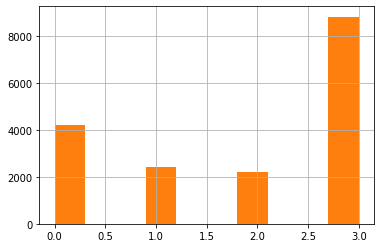

In [20]:
# # solve: LightGBMError: Do not support special JSON characters in feature name.
# reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
# ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]
# features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]


# def LGB_CV(
#           max_depth,
#           learning_rate,
#           bagging_freq,
#           bagging_fraction,
#           colsample_bytree,
# #           feature_fraction,
#           lambda_l1,
#           lambda_l2,
#           target='accuracy_group',
#           categoricals=['session_title']
#          ):
#     train_df = reduce_train

#     folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
# #     folds = GroupKFold(n_splits=5)
    
#     cv = folds.split(reduce_train, reduce_train[target])
    
#     param = {
#         'objective':'regression',
#         "boosting_type": "gbdt",
#         'metric': 'rmse',
#         'eval_metric': 'cappa',
#         "bagging_seed": 11,
#         "metric": 'rmse',
#         'early_stopping_rounds': 150,
#         'verbose': 100,
#         "verbosity": -1,
#         'seed': 42,
#         'bagging_freq': int(bagging_freq),
#         'colsample_bytree': colsample_bytree,
#         'max_depth': int(max_depth),
#         'learning_rate': learning_rate,
# #         "feature_fraction": feature_fraction,
#         "bagging_fraction": bagging_fraction,
#         "lambda_l1": lambda_l1,
#         "lambda_l2": lambda_l2,
#     }
    
    
#     oof_pred = np.zeros(train_df.shape[0])
#     for fold, (train_idx, val_idx) in enumerate(cv):
        
#         x_train, x_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]   
#         y_train, y_val = train_df[target][train_idx], train_df[target][val_idx]

#         train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
#         val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)
        
#         clf = lgb.train(param, train_set, 10000, valid_sets = [train_set, val_set], verbose_eval=100, early_stopping_rounds=100)
        
#         oof_pred[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
        
#         print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        
#         del clf, train_idx, val_idx
#         gc.collect()
#     _, loss_score, _ = eval_qwk_lgb_regr(train_df[target], oof_pred)    
#     print('Our oof cohen kappa score is: ', loss_score)
#     # return -mean_squared_error(oof, target)**0.5
#     return loss_score

# LGB_BO = BayesianOptimization(LGB_CV, {
#     'max_depth': (8, 12),
# #     'feature_fraction': (0.4, 1.0),
#     'bagging_freq': (1, 10),
#     'bagging_fraction': (0.4, 1.0),
#     'lambda_l1': (0, 6),
#     'lambda_l2': (0, 6),
#     'learning_rate': (0.025, 0.1),
#     'colsample_bytree': (0.4, 0.6)
#     })

# print('-'*126)

# start_time = timer(None)
# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0, random_state=1000)
# timer(start_time)

In [21]:
# print('-'*130)
# print('Final Results')
# print('Maximum  value: %f' % LGB_BO.max['target'])
# print('Best  parameters:', LGB_BO.max['params'])

# if LGB_BO.max['target'] > 0.596892:
#     LGB_pramas = LGB_BO.max['params']
# else:
#     LGB_pramas = {'bagging_fraction': 0.6213539389522488, 'bagging_freq': 1.4748145384253637, 'colsample_bytree': 0.4754932106051242, 'lambda_l1': 5.9912219570411995, 'lambda_l2': 5.930332925462399, 'learning_rate': 0.030101090836408384, 'max_depth': 8.118001952478933}

# Final Results
# Maximum  value: 0.598539
# Best  parameters: {'bagging_fraction': 0.6213539389522488, 'bagging_freq': 1.4748145384253637, 'colsample_bytree': 0.4754932106051242, 'lambda_l1': 5.9912219570411995, 'lambda_l2': 5.930332925462399, 'learning_rate': 0.030101090836408384, 'max_depth': 8.118001952478933}

----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum  value: 0.598539
Best  parameters: {'bagging_fraction': 0.6213539389522488, 'bagging_freq': 1.4748145384253637, 'colsample_bytree': 0.4754932106051242, 'lambda_l1': 5.9912219570411995, 'lambda_l2': 5.930332925462399, 'learning_rate': 0.030101090836408384, 'max_depth': 8.118001952478933}


In [22]:
class Base_Model(object):
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True, params=None):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params(params)
        self.y_pred, self.oof_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
#         cv = GroupKFold(n_splits=self.n_splits)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self, params):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            # 相当于降维
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]   
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            # 针对不同模型处理数据
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            # 针对不同模型训练数据
            model = self.train_model(train_set, val_set) 
            # 得到验证数据的预测值
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            # 得到测试数据的预测值
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, oof_pred, loss_score, model

In [23]:
class Lgb_Model(Base_Model):
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self, params=None):
        if params is None :
            default_params = {
                'n_estimators':2000,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'n_jobs': -1,
                'eval_metric': 'cappa',
                'subsample': 0.75,
                'subsample_freq': 1,
                'learning_rate': 0.01,
                'feature_fraction': 0.9,
                'max_depth': 15,
                'lambda_l1': 1,  
                'lambda_l2': 1,
                'early_stopping_rounds': 100}
        else:
            default_params = {
                "bagging_seed": 11,
                'verbose': 100,
                "verbosity": -1,
                'seed': 42,
                'n_estimators':2000,
                'subsample': 0.75,
                'subsample_freq': 1,
                'n_jobs': -1,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'early_stopping_rounds': 100,
                'eval_metric': 'cappa',
                'learning_rate': params['learning_rate'],
#                 'feature_fraction': params['feature_fraction'],
                'colsample_bytree': params['colsample_bytree'], 
                'bagging_fraction': params['bagging_fraction'],
                'bagging_freq': int(params['bagging_freq']),
                'max_depth': int(params['max_depth']),
                'lambda_l1': params['lambda_l1'],  
                'lambda_l2': params['lambda_l2']}
        return default_params

In [24]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, 
                         train_set, 
                         num_boost_round=5000, 
                         evals=[(train_set, 'train'), 
                                (val_set, 'val')], 
                         verbose_eval=verbosity,
                         early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self, params=None):
        if params is None :
            default_params = {
                      'colsample_bytree': 0.8,                 
                      'learning_rate': 0.01,
                      'max_depth': 10,
                      'subsample': 1,
                      'objective':'reg:squarederror',
                      #'eval_metric':'rmse',
                      'min_child_weight':3,
                      'gamma':0.25,
                      'n_estimators':2000}
        else:
            default_params = {
                  'colsample_bytree': params['colsample_bytree'],                 
                  'learning_rate': 0.01,
                  'max_depth': int(params['max_depth']),
                  'subsample': params['subsample'],
                  'objective':'reg:squarederror',
                  #'eval_metric':'rmse',
                  'min_child_weight':params['min_child_weight'],
                  'gamma': params['gamma'],
                  'n_estimators':2000,
                  'max_delta_step': params['max_delta_step']}
        return default_params

In [25]:
# solve: LightGBMError: Do not support special JSON characters in feature name.
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]
features_copy = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features_copy]

Found `n_estimators` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.950226	valid_1's rmse: 1.00713
[200]	training's rmse: 0.895671	valid_1's rmse: 0.991189
[300]	training's rmse: 0.862557	valid_1's rmse: 0.989945
Early stopping, best iteration is:
[274]	training's rmse: 0.870337	valid_1's rmse: 0.989514
Partial score of fold 0 is: 0.5812934107569538
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.953338	valid_1's rmse: 1.00006
[200]	training's rmse: 0.898649	valid_1's rmse: 0.984667
[300]	training's rmse: 0.865008	valid_1's rmse: 0.982025
Early stopping, best iteration is:
[295]	training's rmse: 0.866412	valid_1's rmse: 0.981924
Partial score of fold 1 is: 0.5984711169823096
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.951653	valid_1's rmse: 1.00448
[200]	training's rmse: 0.896622	valid_1's rmse: 0.986857
[300]	training's rmse: 0.86287	valid_1's rmse: 0.98502
Early stopping, best iterati

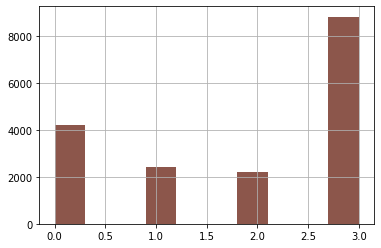

In [29]:
lgb_model = Lgb_Model(reduce_train, ajusted_test, features_copy, categoricals=categoricals, params=LGB_pramas)

In [27]:
features_copy = features.copy()
features_copy = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features_copy].shape, ajusted_test.shape, len(features_copy), categoricals

((17690, 563), (1000, 1032), 563, ['session_title'])

|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
[0]	train-rmse:1.72839	val-rmse:1.74187
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.53262	val-rmse:1.02487
Stopping. Best iteration:
[31]	train-rmse:0.644028	val-rmse:1.01893

Partial score of fold 0 is: 0.5480116049453271
[0]	train-rmse:1.72815	val-rmse:1.74038
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.533375	val-rmse:1.00539
Stopping. Best iteration:
[32]	train-rmse:0.640448	val-rmse:1.00068

Partial score of fold 1 is: 0.5734202954036658
[0]	train-rmse:1.72801	val-rmse:1.74035
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.370698	val-rmse:1.01294
Stopping. Best iteration:
[60]	train-rmse:0.460519	val-rmse:1.00833

Partial score of fold 4 is: 0.5680346371047764
|  4        |  0.5648   |  0.4304   |  0.09151  |  0.2321   |  10.51    |  0.1693   |  0.9888   |
[0]	train-rmse:1.73318	val-rmse:1.74044
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.808353	val-rmse:0.999984
Stopping. Best iteration:
[53]	train-rmse:0.808367	val-rmse:0.999974

Partial score of fold 0 is: 0.5699797865225346
[0]	train-rmse:1.73253	val-rmse:1.73965
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.803609	val-rmse:0.990984
Stopping. Best iteration:
[67]	train-rmse:0.80361	val-rmse:0.990984

Partial score of fold 1 is: 0.5868403783922249
[

[200]	train-rmse:0.969232	val-rmse:0.990695
[300]	train-rmse:0.954755	val-rmse:0.991745
Stopping. Best iteration:
[222]	train-rmse:0.96578	val-rmse:0.990253

Partial score of fold 4 is: 0.5883477184569403
|  8        |  0.582    |  1.0      |  0.8721   |  0.0      |  2.0      |  20.0     |  0.4      |
[0]	train-rmse:1.74636	val-rmse:1.74668
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.956244	val-rmse:1.00424
[200]	train-rmse:0.935878	val-rmse:1.00316
Stopping. Best iteration:
[157]	train-rmse:0.942827	val-rmse:1.00214

Partial score of fold 0 is: 0.5698416066067167
[0]	train-rmse:1.7466	val-rmse:1.74702
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.958186	val-rmse:1.00065
[200]	train-rmse:0.937632	val-rmse:0.998078
[300]	train-rmse:0.926042	val-rmse:0.997648


[100]	train-rmse:0.990296	val-rmse:0.997093
[200]	train-rmse:0.973832	val-rmse:0.992775
[300]	train-rmse:0.970488	val-rmse:0.991651
Stopping. Best iteration:
[244]	train-rmse:0.970828	val-rmse:0.991545

Partial score of fold 3 is: 0.5877350505914622
[0]	train-rmse:1.74914	val-rmse:1.74809
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.988899	val-rmse:1.00016
[200]	train-rmse:0.974256	val-rmse:0.995332
[300]	train-rmse:0.971806	val-rmse:0.994475
Stopping. Best iteration:
[273]	train-rmse:0.971806	val-rmse:0.994475

Partial score of fold 4 is: 0.5859325183102964
|  12       |  0.5795   |  0.9542   |  7.089    |  8.917    |  2.116    |  0.6587   |  0.9907   |
[0]	train-rmse:1.74851	val-rmse:1.74876
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.986682	val-rmse:1.01

Partial score of fold 4 is: 0.5900490309875659
|  15       |  0.5852   |  0.9693   |  3.366    |  0.2146   |  2.604    |  4.048    |  0.881    |
[0]	train-rmse:1.7487	val-rmse:1.74892
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.986604	val-rmse:1.01215
[200]	train-rmse:0.966238	val-rmse:1.00883
Stopping. Best iteration:
[161]	train-rmse:0.972833	val-rmse:1.00853

Partial score of fold 0 is: 0.5673365244488523
[0]	train-rmse:1.74937	val-rmse:1.74973
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.988114	val-rmse:1.01321
[200]	train-rmse:0.968207	val-rmse:1.00625
[300]	train-rmse:0.954537	val-rmse:1.00241
[400]	train-rmse:0.943298	val-rmse:1.00143
Stopping. Best iteration:
[394]	train-rmse:0.943859	val-rmse:1.00129

Partial score of fold 1 is: 0.5882718539110046


Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.823046	val-rmse:0.992612
[200]	train-rmse:0.807389	val-rmse:0.993187
Stopping. Best iteration:
[115]	train-rmse:0.821128	val-rmse:0.992455

Partial score of fold 1 is: 0.5864825095125301
[0]	train-rmse:1.73568	val-rmse:1.74047
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.822926	val-rmse:0.990449
Stopping. Best iteration:
[77]	train-rmse:0.828599	val-rmse:0.990297

Partial score of fold 2 is: 0.5925662804673435
[0]	train-rmse:1.7356	val-rmse:1.74117
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.821407	val-rmse:0.981241
Stopping. Best iteration:
[96]	train-rmse:0.822355	val-rmse:0.981055

Partial score 

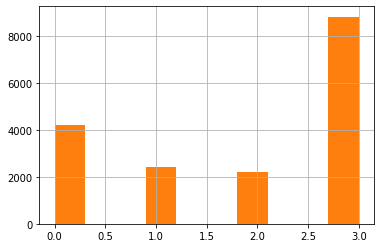

In [34]:
# # Comment out any parameter you don't want to test
# def XGB_CV(
#           max_depth,
#           gamma,
#           min_child_weight,
#           max_delta_step,
#           subsample,
#           colsample_bytree,
#           target='accuracy_group',
#           verbosity=100
#          ):

#     train_df = reduce_train

#     folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
#     cv = folds.split(reduce_train, reduce_train[target])
    
#     params = {
#       'booster' : 'gbtree',
#       'max_depth' : int(max_depth),
#       'gamma' : gamma,
#       'eta' : 0.1,
#       'nthread' : 4,
#       'silent' : True,
# #       'eval_metric': 'auc',
#       'subsample' : max(min(subsample, 1), 0),
#       'colsample_bytree' : max(min(colsample_bytree, 1), 0),
#       'min_child_weight' : min_child_weight,
#       'max_delta_step' : int(max_delta_step),
#       'seed' : 1001,
#       'objective':'reg:squarederror',
#     }
    
    
#     oof_pred = np.zeros(train_df.shape[0])
#     for fold, (train_idx, val_idx) in enumerate(cv):
        
#         x_train, x_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]   
#         y_train, y_val = train_df[target][train_idx], train_df[target][val_idx]

#         train_set = xgb.DMatrix(x_train, y_train)
#         val_set = xgb.DMatrix(x_val, y_val)
        
#         clf = xgb.train(params, 
#                          train_set, 
#                          num_boost_round=5000, 
#                          evals=[(train_set, 'train'), 
#                                 (val_set, 'val')], 
#                          verbose_eval=verbosity,
#                          early_stopping_rounds=100)
        
#         oof_pred[val_idx] = clf.predict(xgb.DMatrix(train_df.iloc[val_idx][features]))

#         print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        
#         del clf, train_idx, val_idx
#         gc.collect()
#     _, loss_score, _ = eval_qwk_lgb_regr(train_df[target], oof_pred)    
#     print('Our oof cohen kappa score is: ', loss_score)

# #     return -mean_squared_error(oof, target)**0.5
#     return loss_score

    
# XGB_BO = BayesianOptimization(XGB_CV, {
#                                      'max_depth': (2, 12),
#                                      'gamma': (0.001, 10.0),
#                                      'min_child_weight': (0, 20),
#                                      'max_delta_step': (0, 10),
#                                      'subsample': (0.4, 1.0),
#                                      'colsample_bytree' :(0.4, 1.0)
#                                     })

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     XGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

In [35]:
# print('-'*130)
# print('Final Results')
# print('Maximum  value: %f' % XGB_BO.max['target'])
# print('Best  parameters:', XGB_BO.max['params'])



# if XGB_BO.max['target'] > 0.592347:
#     XGB_params = XGB_BO.max['params']
# else:
#     XGB_params = {
#     'colsample_bytree': 0.5718422563102614,
#     'gamma': 9.121035497281943,
#     'max_delta_step': 1.070668157937703, 
#     'max_depth': 8.29419083806185, 
#     'min_child_weight': 0.6493316414338923,
#     'subsample': 0.6592648167510096}
    
# # Maximum  value: 0.592347   # 0.538
# # Best  parameters: {
# #     'colsample_bytree': 0.5718422563102614,
# #     'gamma': 9.121035497281943,
# #     'max_delta_step': 1.070668157937703, 
# #     'max_depth': 8.29419083806185, 
# #     'min_child_weight': 0.6493316414338923,
# #     'subsample': 0.6592648167510096}

----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum  value: 0.591166
Best  parameters: {'colsample_bytree': 0.8385855877831687, 'gamma': 9.78703082065715, 'max_delta_step': 9.978971185581143, 'max_depth': 5.788939386673138, 'min_child_weight': 19.371617583426954, 'subsample': 0.9390899087314895}


[0]	train-rmse:1.86271	val-rmse:1.86285
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.21261	val-rmse:1.24397
[200]	train-rmse:0.962815	val-rmse:1.04086
[300]	train-rmse:0.897218	val-rmse:1.00011
[400]	train-rmse:0.87133	val-rmse:0.989685
[500]	train-rmse:0.858957	val-rmse:0.986451
[600]	train-rmse:0.85072	val-rmse:0.985238
[700]	train-rmse:0.845792	val-rmse:0.984819
[800]	train-rmse:0.841935	val-rmse:0.98465
[900]	train-rmse:0.839323	val-rmse:0.984357
[1000]	train-rmse:0.836656	val-rmse:0.984295
[1100]	train-rmse:0.83413	val-rmse:0.984006
[1200]	train-rmse:0.832198	val-rmse:0.984011
[1300]	train-rmse:0.830424	val-rmse:0.983873
[1400]	train-rmse:0.828506	val-rmse:0.983769
[1500]	train-rmse:0.826591	val-rmse:0.983751
[1600]	train-rmse:0.825329	val-rmse:0.983565
[1700]	train-rmse:0.823976	val-rmse:0.983533
[1800]	train-rmse:0.822654	val-rmse:0.983426
[1900]	train-rmse:0.82103

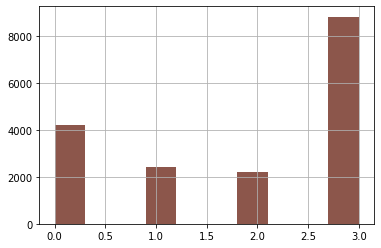

In [36]:
xgb_model = Xgb_Model(reduce_train, ajusted_test, features_copy, categoricals=categoricals, params=XGB_params)

In [42]:
final_pred = lgb_model.y_pred * 0.8 + xgb_model.y_pred * 0.2

{0: 1.4827951869746674, 1: 1.9164307153342817, 2: 2.1240703704860424}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

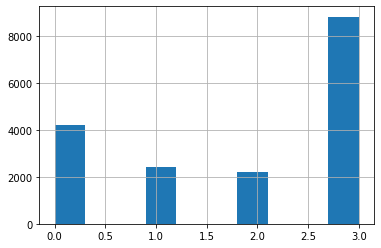

In [43]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

# lgb_model
# bound[0] = 1.18253215
# bound[1] = 1.81532098
# bound[2] = 2.17071483

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)